In [31]:
from datasets_dgl.data_dgl import *
from  easydict  import EasyDict
from datasets_dgl.utils import to_scipy,sparse_mx_to_torch_sparse_tensor

seed = 15
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.set_device(0)  # 指第几块GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_name = 'Attack-Cora'
dataname  = 'cora'
no_attack = 'Meta_Self-0.0'
ptb_rate = 0.4

################# no attack
DATASET0 = EasyDict()
DATASET0.ATTACK = {
    "data":dataset_name,
    "attack":no_attack.split('-')[0],
    "ptb_rate":no_attack.split('-')[1]
    # "train_size":0.5,
    # "val_size":0.2,
    # "test_size":0.3,
    # "group":5, # train_size * 10
    # "use_g1_split":False
}
dataset  = load_attack_data(DATASET0['ATTACK'])
graph = dataset.graph
graph = dgl.remove_self_loop(graph) # 如果不可视化自环的话就用


adj = graph.adj().to_dense()
adj = adj.to(device)

features  = graph.ndata['feat']
labels    = graph.ndata['label'].numpy()

idx_train = graph.ndata['train_mask'].nonzero().squeeze().numpy()
idx_val = graph.ndata['val_mask'].nonzero().squeeze().numpy()
idx_test = graph.ndata['test_mask'].nonzero().squeeze().numpy()
n_perturbations = int(adj.sum().item() * ptb_rate / 2)

idx_unlabeled = np.union1d(idx_val, idx_test)
idx_all = np.union1d(idx_unlabeled, idx_train)
for i in range(len(adj)):
    if i not in idx_all:
        idx_unlabeled = np.union1d(idx_unlabeled, i)


[I] Loading dataset Attack-Cora...
train_mask, test_mask, val_mask sizes : tensor(247) tensor(249) tensor(1988)
[I] Finished loading.
[I] Data load time: 0.0249s


In [32]:
import torch
import argparse
import pickle as pkl
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# 计算lamda
def compute_lambda(adj, idx_train, idx_test):
    num_all = adj.sum().item() / 2
    train_train = adj[idx_train][:, idx_train].sum().item() / 2
    test_test = adj[idx_test][:, idx_test].sum().item() / 2
    train_test = num_all - train_train - test_test
    return train_train / num_all, train_test / num_all, test_test / num_all

# 对指定的元路径进行攻击
def heuristic_attack(specific_meta_path_graph, n_perturbations, idx_train, idx_unlabeled):
    #2.2 attack adjs
    adj = specific_meta_path_graph
    assert sum(sum(adj - adj.t())) == 0 # 判断是否对称

    # 计算lamda
    lambda_1, lambda_2, lambda_3 = compute_lambda(adj, idx_train, idx_unlabeled)
    # print(lambda_1,lambda_2,lambda_3)

    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_unlabeled)
    degree = adj.sum(dim=1).to('cpu')
    canditate_train_idx = idx_train[degree[idx_train] < (int(degree.mean()) + 1)]
    candidate_test_idx = idx_test[degree[idx_test] < (int(degree.mean()) + 1)]

    perturbed_adj = adj.clone()
    cnt = 0
    train_ratio = lambda_1 / (lambda_1 + lambda_2) # 这里论文中假设的是训练集要远小于测试集，所以按照这样的方式
    n_train = int(n_perturbations * train_ratio)
    n_test = n_perturbations - n_train

    # perturbed train train
    while cnt < n_train:
        node_1 = np.random.choice(canditate_train_idx, 1)
        node_2 = np.random.choice(canditate_train_idx, 1)
        if labels[node_1] != labels[node_2] and adj[node_1, node_2] == 0:
            perturbed_adj[node_1, node_2] = 1
            perturbed_adj[node_2, node_1] = 1
            cnt += 1

    # perturbed train test
    cnt = 0
    while cnt < n_test:
        node_1 = np.random.choice(canditate_train_idx, 1)
        node_2 = np.random.choice(candidate_test_idx, 1)
        if labels[node_1] != labels[node_2] and perturbed_adj[node_1, node_2] == 0:
            perturbed_adj[node_1, node_2] = 1
            perturbed_adj[node_2, node_1] = 1
            cnt += 1
    return perturbed_adj

In [33]:
perturbed_adj = heuristic_attack(adj, n_perturbations, idx_train, idx_unlabeled)

In [34]:
# save
from datasets_dgl.utils import sparse_mx_to_torch_sparse_tensor
import scipy

save_path = '/home/songsh/datasets_dgl/all_data_attack/heuristic/'

save_adj  = sparse_mx_to_torch_sparse_tensor(to_scipy(perturbed_adj))
features  = features.cpu()
labels    = labels
train_idx = idx_train
val_idx   = idx_val
test_idx  = idx_test


torch.save(save_adj,   save_path +  '%s/heuristic_%s_%s.pt' % (dataname,  dataname, ptb_rate))

if ptb_rate == 0: #保存一次label和features即可
    scipy.sparse.save_npz(save_path + '%s/%s_features' % (dataname,  dataname), scipy.sparse.csr_matrix(np.array(features)))
    np.save(save_path + '%s/%s_labels' % (dataname, dataname),   labels)

np.save( save_path + '%s/heuristic_%s_%s_idx_train'  % (dataname, dataname, ptb_rate),   train_idx)
np.save( save_path + '%s/heuristic_%s_%s_idx_val'    % (dataname, dataname, ptb_rate),     val_idx)
np.save( save_path + '%s/heuristic_%s_%s_idx_test'   % (dataname, dataname, ptb_rate),    test_idx)

In [35]:
from   datasets_dgl.data_dgl  import load_attack_data
from     easydict        import EasyDict

# dataset_name = dataset_name.split('-')[1]
DATASET = EasyDict()
DATASET.ATTACK = {
    "data"    :  dataset_name,
    "attack"  :  'heuristic',
    "ptb_rate":  str(ptb_rate)
}
# now just attack use
dataset  = load_attack_data(DATASET['ATTACK'])
graph = dataset.graph
graph

[I] Loading dataset Attack-Cora...
train_mask, test_mask, val_mask sizes : tensor(247) tensor(249) tensor(1988)
[I] Finished loading.
[I] Data load time: 0.0250s


Graph(num_nodes=2485, num_edges=16677,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [36]:
from deeprobust.graph.defense import GCN
model = GCN(nfeat=features.shape[1], nhid=16, nclass=labels.max()+1, device=device)
model = model.to(device)

labels  = torch.LongTensor(labels)

model.fit(features, perturbed_adj, labels, idx_train, idx_val, train_iters=200, verbose=True)

model.eval()
# You can use the inner function of model to test
model.test(idx_test)

=== training gcn model ===
Epoch 0, training loss: 1.951598048210144
Epoch 10, training loss: 1.4337158203125
Epoch 20, training loss: 0.9715678691864014
Epoch 30, training loss: 0.5954764485359192
Epoch 40, training loss: 0.3942912817001343
Epoch 50, training loss: 0.25160032510757446
Epoch 60, training loss: 0.19229087233543396
Epoch 70, training loss: 0.145719975233078
Epoch 80, training loss: 0.14295139908790588
Epoch 90, training loss: 0.13193181157112122
Epoch 100, training loss: 0.12277598679065704
Epoch 110, training loss: 0.11352650076150894
Epoch 120, training loss: 0.0887327715754509
Epoch 130, training loss: 0.10312795639038086
Epoch 140, training loss: 0.10930173099040985
Epoch 150, training loss: 0.10222931206226349
Epoch 160, training loss: 0.09696245193481445
Epoch 170, training loss: 0.08238430321216583
Epoch 180, training loss: 0.06952723115682602
Epoch 190, training loss: 0.06761030107736588
=== picking the best model according to the performance on validation ===
Te

0.6926559356136821

In [37]:
def adjust_idx(adj, idx_train, idx_unlabeled):
    new_adj = adj.clone()
    new_adj[:len(idx_train)][:, :len(idx_train)] = adj[idx_train][:, idx_train]
    new_adj[len(idx_train):][:, :len(idx_train)] = adj[idx_unlabeled][:, idx_train]
    new_adj[:len(idx_train)][:, len(idx_train):] = adj[idx_train][:, idx_unlabeled]
    new_adj[len(idx_train):][:, len(idx_train):] = adj[idx_unlabeled][:, idx_unlabeled]
    return new_adj

In [38]:
changed = torch.abs(perturbed_adj - adj)

adj             = adjust_idx(adj, idx_train, idx_unlabeled)
perturbed_adj   = adjust_idx(perturbed_adj, idx_train, idx_unlabeled)
changed         = adjust_idx(changed, idx_train, idx_unlabeled)

perturbed_adj = to_scipy(perturbed_adj)
adj           = to_scipy(adj)
changed       = to_scipy(changed)

In [39]:
font1 = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size'   : 20,
}

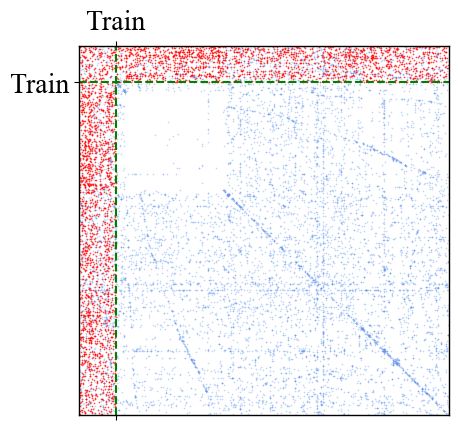

In [40]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default') # 风格设置默认即可，要不是全黑

adj_view = changed
ax = plt.gca()
ax.spines['bottom'].set_linewidth('1.0')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth('1.0')
ax.spines['left'].set_color('black')
ax.spines['top'].set_linewidth('1.0')
ax.spines['top'].set_color('black')
ax.spines['right'].set_linewidth('1.0')
ax.spines['right'].set_color('black')
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.spy(adj_view, markersize=0.2, color='r')
plt.spy(adj, markersize=0.2, color='cornflowerblue', alpha=0.5)
plt.yticks([len(idx_train)], ['Train'], font=font1)
plt.xticks([len(idx_train)], ['Train'], font=font1)
plt.axvline(len(idx_train), color="green", ls='--')
plt.axhline(len(idx_train), color="green", ls='--')
# plt.savefig('%s_distribution.pdf'%(args.dataset),dpi=800, format='pdf', bbox_inches = 'tight')
plt.show()